# Wasserstein GAN

- <a href="https://arxiv.org/abs/1701.07875">Paper</a>
- <a href="https://github.com/martinarjovsky/WassersteinGAN/blob/master/main.py">Original pytorch implementation</a>

In [69]:
import numpy as np
import tensorflow as tf

import load_mnist
import tflearn

from scipy import signal

%matplotlib inline
from IPython import display
from IPython.core.pylabtools import figsize
from seaborn import plt
from matplotlib import cm

## Net Architectures

#### Multi-Layer Perceptron

In [2]:
def initializer(stddev):
    return tflearn.initializations.truncated_normal(stddev=stddev)

def fc(inp, n=256, act="relu", w_std=0.02):
    return tflearn.fully_connected(
        inp, n,
        activation=act,
        weights_init=initializer(w_std))

In [3]:
def mlp_generator():
    nonce = "Generator-{}".format(np.random.randint(2 ** 32))
    with tf.variable_scope(nonce) as scope:
        inp = tflearn.input_data(shape=[None, 64])
        net = fc(fc(fc(inp)))
        net = fc(net, n=28 * 28)
        net = tflearn.reshape(net, [-1, 28, 28])
    return (
        inp, net,
        [v for v in tflearn.get_all_trainable_variable() if nonce in v.name])

In [4]:
def mlp_critic(inp=None):
    nonce = "Critic-{}".format(np.random.randint(2 ** 32))
    with tf.variable_scope(nonce) as scope:
        if inp is None:
            inp = tflearn.input_data(shape=[None, 28, 28])
        net = tflearn.flatten(inp)
        net = fc(fc(fc(net)))
        net = fc(net, n=1, act="linear")
    return (
        inp, net,
        [v for v in tflearn.get_all_trainable_variable() if nonce in v.name])

#### Conv-Pool

In [5]:
def cp(ch, inp, size=3, stride=2, act="leakyrelu", w_std=0.005):
    conv = tflearn.conv_2d(
        inp, ch, size,
        strides=stride,
        activation=act,
        weights_init=initializer(w_std))
    return tflearn.max_pool_2d(conv, 2)

In [6]:
def conv_critic(inp=None):
    nonce = "Critic-{}".format(np.random.randint(2 ** 32))
    with tf.variable_scope(nonce) as scope:
        if inp is None:
            inp = tflearn.input_data(shape=[None, 28, 28])
        net = tflearn.reshape(inp, [-1, 28, 28, 1])
        net = tflearn.flatten(cp(128, cp(64, net)))
        net = fc(net, n=1024, act="leakyrelu")
        net = fc(net, n=1, act="linear")
    return (
        inp, net,
        [v for v in tflearn.get_all_trainable_variable() if nonce in v.name])

## Adversarial Trainer

In [7]:
def get_session(s):
    return s or tf.get_default_session() or tf.InteractiveSession()

In [8]:
class Generator(object):
    
    def __init__(self, instantiator, kwargs={}, sess=None):
        self.sess = get_session(sess)
        self.inp, self.outp, self.trainable = instantiator(**kwargs)
        self.code_size = int(self.inp.get_shape()[1])
        
    def noise(self, n):
        return np.random.normal(0, 1, (n, self.code_size))
    
    def generate(self, n_or_codes):
        if isinstance(n_or_codes, int):
            codes = self.noise(n_or_codes)
        else:
            codes = n_or_codes
        return self.outp.eval(feed_dict={self.inp: codes})

In [9]:
class Critic(object):
    
    def __init__(self, gen_outp, instantiator, kwargs={}, sess=None, lipschitz_k=0.01, lr=5e-5):
        self.sess = get_session(sess)
        self.lipschitz_k = lipschitz_k
        self.lr = lr
        self.inp, self.outp, self.trainable = instantiator(gen_outp, **kwargs)
        
        # Training Ops
        self.is_real = tf.placeholder(tf.float32, [None, 1])
        self.real_quality = (
            tf.reduce_sum(self.outp * self.is_real) /
            tf.reduce_sum(self.is_real))
        self.fake_quality = (
            tf.reduce_sum(self.outp * (1 - self.is_real)) /
            tf.reduce_sum(1 - self.is_real))
        self.loss = self.fake_quality - self.real_quality
        self.optimizer = tf.train.RMSPropOptimizer(self.lr, momentum=0.0)
        self.train_op = self.optimizer.minimize(
            self.loss,
            var_list=self.trainable)
        self.clip_ops = self.get_clip_ops()
    
    def get_clip_ops(self):
        with tf.control_dependencies([self.train_op]):
            return [
                v.assign(tf.clip_by_value(
                    v, -self.lipschitz_k, self.lipschitz_k))
                for v in self.trainable]
    
    def train_batch(self, real, fake):
        all_inp = np.concatenate([real, fake], 0)
        is_real = np.concatenate(
            [np.ones([real.shape[0], 1]), np.zeros([fake.shape[0], 1])],
            0)
        loss, real_quality, fake_quality = self.sess.run(
            [self.loss, self.real_quality, self.fake_quality, self.train_op] + self.clip_ops,
            feed_dict={
                self.inp: all_inp,
                self.is_real: is_real})[:3]
        return loss, real_quality, fake_quality

In [10]:
def image_batch_iterator(ims, batch_size):
    n_ims = ims.shape[0]
    ixs = np.arange(n_ims)
    cursor = 0
    while True:
        if cursor + batch_size > n_ims:
            cursor = 0
        if cursor == 0:
            np.random.shuffle(ixs)
        yield ims[ixs[cursor:cursor + batch_size]]
        cursor += batch_size

In [28]:
class WGAN(object):
    
    def __init__(
            self, gen_inst, crit_inst, images,
            batch_size=64, n_samples=16, lr=5e-5, lipschitz_k=0.01,
            critic_reps=5, generator_reps=1, sprint_reps=100, sprint_every=500,
            generator_kwargs={}, critic_kwargs={}, sess=None):
        self.image_batcher = image_batch_iterator(images, batch_size)
        self.n_samples = n_samples
        self.batch_size = batch_size
        self.sess = get_session(sess)
        self.critic_reps = critic_reps
        self.generator_reps = generator_reps
        self.sprint_reps = sprint_reps
        self.sprint_every = sprint_every
        self.lr = lr
        self.generator = Generator(
            gen_inst,
            kwargs=generator_kwargs,
            sess=self.sess)
        self.critic = Critic(
            self.generator.outp, crit_inst,
            kwargs=critic_kwargs,
            sess=self.sess,
            lr=self.lr,
            lipschitz_k=lipschitz_k)
        
        # Training Ops
        self.gen_loss = -self.critic.fake_quality
        self.gen_optimizer = tf.train.RMSPropOptimizer(self.lr, momentum=0.0)
        self.gen_train_op = self.gen_optimizer.minimize(
            self.gen_loss,
            var_list=self.generator.trainable)
        
        # Initialize!
        self.sess.run(tf.global_variables_initializer())
        
        # Book-keeping
        self.fixed_noise = self.generator.noise(self.n_samples)
        self.update_steps = 0
        self.image_samples = []
        self.sample_update_steps = []
        self.generator_losses = []
        self.critic_results = []
        self.wasserstein_estimates = []
        self.real_qualities = []
        self.fake_qualities = []
        
    def train(self, n_updates, report_every=10, show_samples_every=10):
        for _ in np.arange(n_updates):
            self.train_batch()
            if self.update_steps == 1 or (self.update_steps % show_samples_every) == 0:
                self.sample_images()
            if self.update_steps == 1 or (self.update_steps % report_every) == 0:
                self.report()
    
    def sample_images(self):
        self.image_samples.append(self.generator.generate(self.fixed_noise))
        self.sample_update_steps.append(self.update_steps)

    def report(self):
        display.clear_output(wait=True)
        print "        Update Steps: {}".format(self.update_steps)
        print "Wasserstein Estimate: {:.8f}".format(np.median(self.wasserstein_estimates[-100:]))
        print "        Real Quality: {:.8f}".format(np.median(self.real_qualities[-100:]))
        print "        Fake Quality: {:.8f}".format(np.median(self.fake_qualities[-100:]))

    def train_batch(self):
        self.update_steps +=1

        # Critic
        critic_results = self.train_critic()
        self.critic_results.append(critic_results)
        critic_loss, real_quality, fake_quality = critic_results[-1]
        self.wasserstein_estimates.append(-critic_loss)
        self.real_qualities.append(real_quality)
        self.fake_qualities.append(fake_quality)
        
        # Generator
        gen_loss = self.train_generator()
        self.generator_losses.append(gen_loss)

    def train_generator(self):
        for _ in np.arange(self.generator_reps):
            gen_loss, _ = self.sess.run(
                [self.gen_loss, self.gen_train_op],
                feed_dict={
                    self.generator.inp: self.generator.noise(self.batch_size),
                    self.critic.is_real: np.zeros([self.batch_size, 1])})
        return gen_loss

    def train_critic(self):
        critic_results = []
        if self.update_steps < 25 or self.update_steps % self.sprint_every == 0:
            critic_reps = self.sprint_reps
        else:
            critic_reps = self.critic_reps
        for _ in np.arange(critic_reps):
            real = self.image_batcher.next()
            fake = self.generator.generate(self.batch_size)
            critic_results.append(self.critic.train_batch(real, fake))
        return critic_results  # list of (batch_loss, real_quality, fake_quality) triples

## Train on MNIST

In [22]:
mnist, _, _, _ = load_mnist.Datasets()
mnist = mnist / 255.0

In [100]:
def summary(wgan, ylim=None, n_samples=3):
    figsize(16, 6)
    plt.plot(np.arange(len(wgan.generator_losses)), wgan.generator_losses, alpha=0.2, label="generator loss")
    plt.plot(np.arange(len(wgan.fake_qualities)), wgan.fake_qualities, alpha=0.2, label="fake quality")
    plt.plot(np.arange(len(wgan.real_qualities)), wgan.real_qualities, alpha=0.2, label="real quality")
    plt.plot(np.arange(len(wgan.wasserstein_estimates)), wgan.wasserstein_estimates, alpha=0.35, color="blue")
    plt.plot(
        np.arange(len(wgan.wasserstein_estimates)),
        signal.medfilt(wgan.wasserstein_estimates, 101),
        color="blue", label="Wasserstein Estimate")
    plt.legend()
    plt.title("lr = {}, critic reps = {}, generator reps = {}".format(
        wgan.lr, wgan.critic_reps, wgan.generator_reps))
    if ylim is not None:
        plt.ylim(0, ylim)
    plt.xlim(0, len(wgan.wasserstein_estimates))
    plt.show()

    figsize(16, 1)
    for j in np.arange(n_samples):
        ims = []
        for i in np.arange(0, len(wgan.image_samples), len(wgan.image_samples) / 16):
            ims.append(wgan.image_samples[i][j])
        plt.imshow(np.minimum(np.concatenate(ims, axis=1), 1))
        plt.axis("off")
        plt.show()

In [62]:
wgan4 = WGAN(
    mlp_generator, mlp_critic, mnist,
    critic_reps=20, generator_reps=1, lr=1e-5, sprint_reps=100)

In [115]:
#wgan4.train(100000)

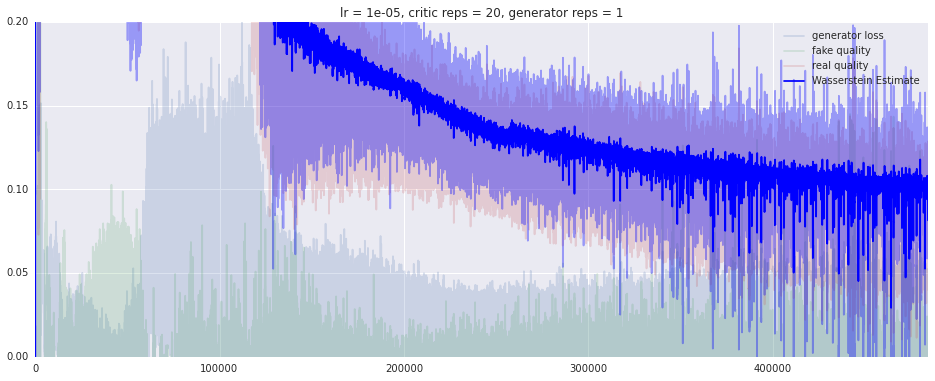

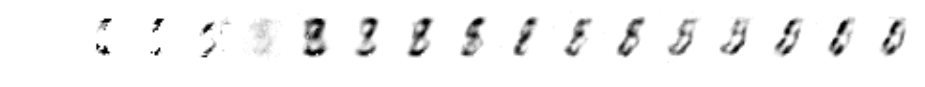

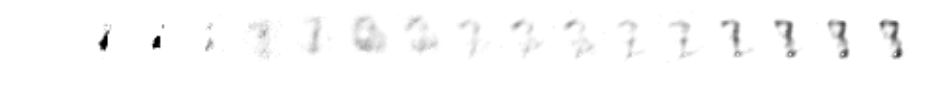

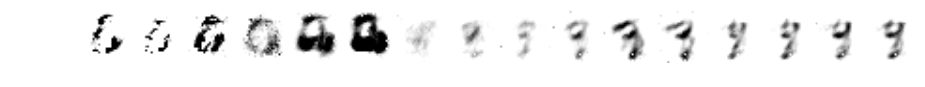

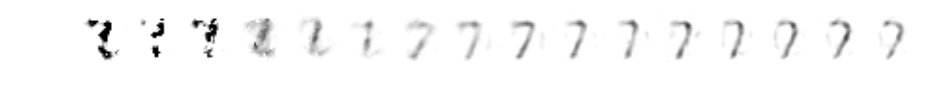

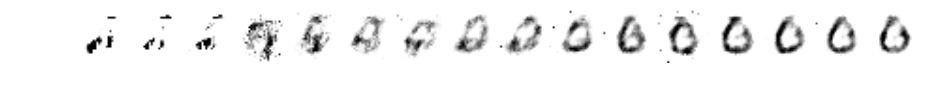

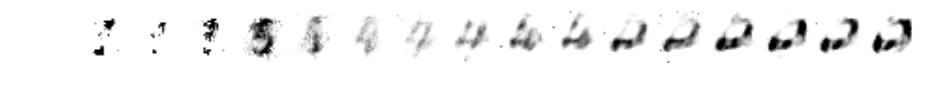

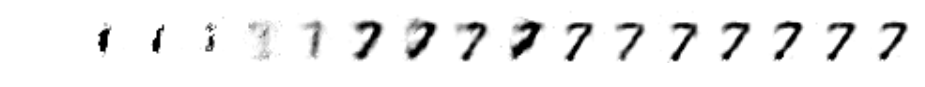

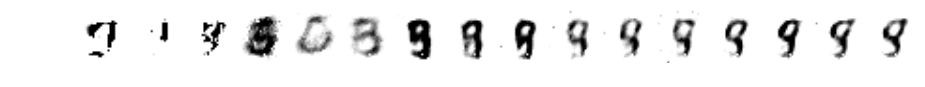

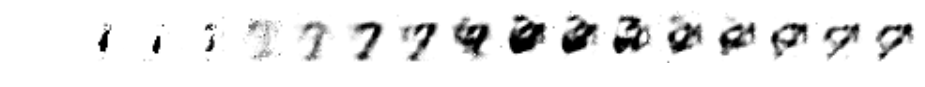

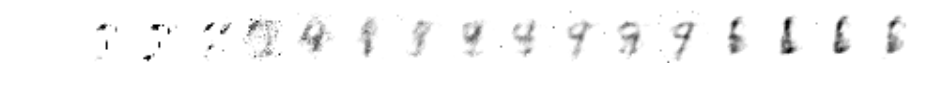

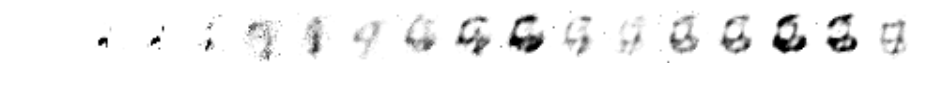

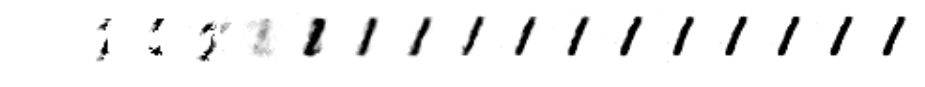

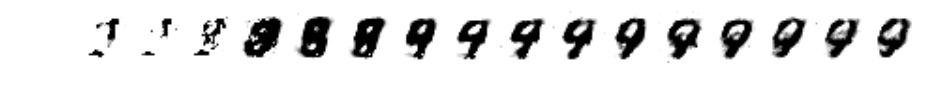

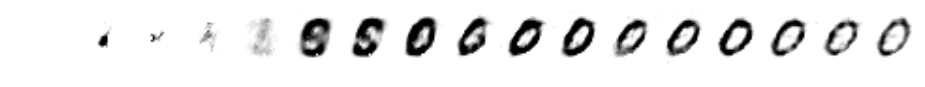

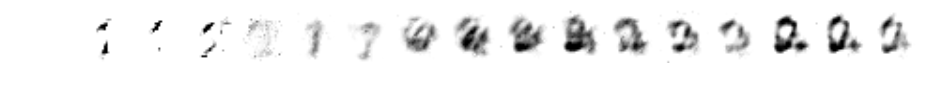

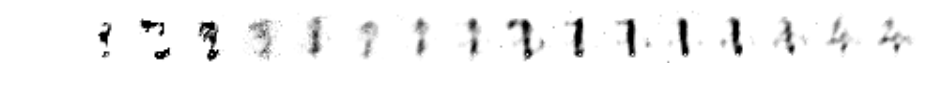

In [109]:
summary(wgan4, ylim=0.2, n_samples=16)